Read the galaxy and random catalogs

In [1]:
import matplotlib.pyplot as plt
import numpy  as np
import fitsio as ft

In [2]:
from nbodykit.transform import SkyToCartesian
from nbodykit.cosmology import Cosmology
import nbodykit.lab as nb

In [3]:
kw = dict(lower=True)
galaxy = ft.read('/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_NGC_v6.dat.fits', **kw)
random = ft.read('/Volumes/TimeMachine/data/eboss/v6/eBOSS_QSO_clustering_NGC_v6.ran.fits', **kw)

In [4]:
print('total number of galaxies and randoms : \n',galaxy.size, random.size)
print('columns in galaxy and random catalogs :\n {} \n {}'.format(galaxy.dtype.names, random.dtype.names))

total number of galaxies and randoms : 
 216893 5565871
columns in galaxy and random catalogs :
 ('ra', 'dec', 'z', 'weight_fkp', 'weight_systot', 'weight_cp', 'weight_noz', 'nz', 'qso_id') 
 ('ra', 'dec', 'z', 'weight_fkp', 'weight_systot', 'weight_cp', 'weight_noz', 'nz')


In [5]:
def prepare(cat, colname='weight', colnames=['weight_noz', 'weight_fkp', 'weight_systot', 'weight_cp']):
    w = np.ones(cat.size, dtype=[('ra', '>f8'), ('dec', '>f8'), ('z', '>f8'), ('nz', '>f8'), ('weight', '>f8'), 
                                ('weight_fkp', '>f8')])
    for coli in colnames:
        print(coli)
        w['weight'] *= cat[coli]
    for coli in ['ra', 'dec', 'z', 'nz', 'weight_fkp']:
        w[coli] = cat[coli]    
    #cat = rfn.merge_arrays([cat, w], flatten=True, usemask=False)    
    return w

prepare galaxy and random catalogs

In [6]:
galaxy0 = prepare(galaxy, colnames=['weight_noz', 'weight_cp'])
galaxy1 = prepare(galaxy, colnames=['weight_noz', 'weight_cp', 'weight_systot']) # will correct for systematics
random0 = prepare(random, colnames=['weight_noz', 'weight_cp', 'weight_systot'])

weight_noz
weight_cp
weight_noz
weight_cp
weight_systot
weight_noz
weight_cp
weight_systot


look at the spatial distribution and n(z) distribution of galaxies and randoms (not-weighted)

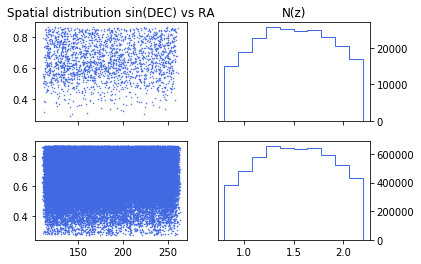

In [7]:
fig, ax = plt.subplots(ncols=2, nrows=2, sharex='col')
ax = ax.flatten()

ax[0].set_title('Spatial distribution sin(DEC) vs RA')
ax[1].set_title('N(z)')
for i, cat in enumerate([galaxy0, random0]):
    ra_s  = np.random.choice(cat['ra'],  replace=False, size=cat.size//100)
    dec_s = np.random.choice(cat['dec'], replace=False, size=cat.size//100)
    ax[2*i].scatter(ra_s, np.sin(np.deg2rad(dec_s)), 1, marker='.', color='royalblue')    
    ax[2*i+1].hist(cat['z'], color='royalblue', histtype='step')
    ax[2*i+1].yaxis.tick_right()

Work with Nbodykit to get P$_{0}$(k)

In [8]:
class powerspectrum(object):
    #
    def __init__(self, data, randoms):            
        #
        # make sure catalogs have the desired format
        #
        cosmo   = Cosmology()
        data    = nb.ArrayCatalog(data)
        randoms = nb.ArrayCatalog(randoms)
        data['position']    = SkyToCartesian(data['ra'],    data['dec'],       data['z'], cosmo=cosmo)
        randoms['position'] = SkyToCartesian(randoms['ra'], randoms['dec'], randoms['z'], cosmo=cosmo)
        #
        self.data    = data
        self.randoms = randoms
        
    def run(self, zlim, nmesh, Poles=[0,2,4], dK=None, kMin=0.0):
        zmin, zmax = zlim
        self.randoms['selection'] = (self.randoms['z'] >= zmin)&(self.randoms['z'] < zmax)
        self.data['selection']    = (self.data['z']    >= zmin)&(self.data['z']    < zmax)
        fkp               = nb.FKPCatalog(self.data, self.randoms)
        fkp['randoms/nz'] = self.randoms['nz']
        fkp['data/nz']    = self.data['nz']
        #fkp['data/FKPWeight']    = 1.0
        #fkp['randoms/FKPWeight'] = 1.0
        mesh              = fkp.to_mesh(Nmesh=nmesh, comp_weight='weight', nbar='nz',
                                        selection='selection', position='position', fkp_weight='weight_fkp')
        #
        # call 
        r = nb.ConvolvedFFTPower(mesh, poles=Poles, dk=dK, kmin=kMin)
        output = {}
        output['attrs'] = r.attrs
        output['attrs']['zbin'] = zlim
        output['poles_data'] = r.poles
        return output

In [9]:
# with systematics
qso0 = powerspectrum(galaxy0, random0)
pk0  = qso0.run([0.8, 2.2], 64, kMin=1.e-3)

In [10]:
# With systematic error correction
qso1 = powerspectrum(galaxy1, random0)
pk1  = qso1.run([0.8, 2.2], 64, kMin=1.e-3)

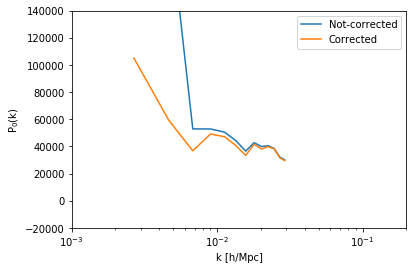

In [11]:
labels = ['Not-corrected', 'Corrected']
for i,pk_i in enumerate([pk0, pk1]):    
    mypk = pk_i['poles_data'].data
    shot = pk_i['attrs']['shotnoise']
    plt.plot(mypk['k'], np.abs(mypk['power_0'])-shot, label=labels[i])
plt.ylabel(r'P$_{0}$(k)')
plt.xscale('log')
plt.ylim(-2e4, 14e4)
plt.xlim(1.e-3, 2.e-1)
plt.xlabel('k [h/Mpc]')
_=plt.legend()